In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from time import time

In [2]:
# Read team match data
def load_dict_from_file_team_season(filepath):
    _dict = {}
    count = 0
    key = []
    try:
        with open(filepath, 'r') as dict_file:
            for line in dict_file:
                if count == 0:
                    key = line.strip().split(',')
                    key[3] = 'PTS1'
                    key[5] = 'PTS2'
                    key[6] = '1'
                    key[7] = '2'
                    count += 1
                    for i in range(len(key)):
                        _dict[key[i]] = []
                    # print(_dict)
                else:
                    value = line.strip().split(',')
                    # print(line)
                    # print(value)
                    for i in range(len(key)):
                        # print(i)
                        _dict[key[i]].append(value[i].strip())
                # (key, value) = line.strip().split(',')
                # _dict[key] = value
    except IOError as ioerr:
        print("文件 %s 不存在" % filepath)
    _dict = pd.DataFrame(_dict)
    return _dict

In [3]:
# Read team ranking data
def load_dict_from_file_team_ranking(filepath):
    _dict = {}
    count = 0
    key = []
    try:
        with open(filepath, 'r') as dict_file:
            for line in dict_file:
                if count == 0:
                    key = line.strip().split(',')
                    for i in range(len(key)):
                        _dict[key[i]] = []
                    count += 1
                    # print(_dict)
                else:
                    value = line.strip().split(',')
                    for i in range(len(key)):
                        _dict[key[i]].append(value[i].strip())
                # (key, value) = line.strip().split(',')
                # _dict[key] = value
    except IOError as ioerr:
        print("文件 %s 不存在" % filepath)
    _dict = pd.DataFrame(_dict)
    return _dict

In [4]:
# Calculate the number of regular season days
def cauculate_day(dataset):
    Day = []
    label = int((dataset['Date'][0].strip().split(' '))[2])
    for i in range(len(dataset['Date'])):
        day = 1
        sign = dataset['Date'][i].strip().split(' ')
        if sign[1] == 'Nov':
            day += 31
        elif sign[1] == 'Dec':
            day += 61
        elif sign[1] == 'Jan':
            day += 92
        elif sign[1] == 'Feb':
            day += 123
        elif sign[1] == 'Mar':
            day += 151
        elif sign[1] == 'Apr':
            day += 182
        elif sign[1] == 'May':
            day += 212
        elif sign[1] == 'Jun':
            day += 243
        # print(int(sign[2]) - label + day)
        Day.append(int(sign[2]) - label + day)
    dataset['Day'] = Day
    return

In [5]:
# Calculate cumulative score
def points_gain(dataset, name_home):
    score = {}
    h_p = []
    v_p = []
    pts_add = {}
    home = []
    visit = []
    for i in range(len(name_home)):
        pts_add[name_home[i]] = 0
        score[name_home[i]] = 0
    # print(score)
    for i in range(len(dataset.index)):
        # Calculate the net points for each game
        pts = dataset['PTS2'][i] - dataset['PTS1'][i]
        pts_add[dataset['Home'][i]] += pts
        pts_add[dataset['Visitor'][i]] -= pts

        # Calculate points for each match: 1 point for a win, 0 points for a loss.
        if dataset['HW'][i] == 1:
            score[dataset['Home'][i]] += 1
        else:
            score[dataset['Visitor'][i]] += 1
        h_p.append(score[dataset['Home'][i]])
        v_p.append(score[dataset['Home'][i]])
        home.append(pts_add[dataset['Home'][i]])
        visit.append(pts_add[dataset['Visitor'][i]])
    dataset['h_pts_add'] = home
    dataset['v_pts_add'] = visit
    dataset['h_score_add'] = h_p
    dataset['v_score_add'] = v_p
    return

In [6]:
# Calculate the performance of the last three home and away games
def recent_behavior(dataset, name_home):
    prew = {}
    for i in range(len(name_home)):
        prew[name_home[i]] = []
    hm1 = []
    vm1 = []
    hm2 = []
    vm2 = []
    hm3 = []
    vm3 = []
    for i in range(len(dataset.index)):
        hteam = dataset['Home'][i]
        vteam = dataset['Visitor'][i]
        if len(prew[hteam]) >= 3:
            hm3.append(prew[hteam][-3])
            hm2.append(prew[hteam][-2])
            hm1.append(prew[hteam][-1])
        elif len(prew[hteam]) >= 2:
            hm3.append('N')
            hm2.append(prew[hteam][-2])
            hm1.append(prew[hteam][-1])
        elif len(prew[hteam]) >= 1:
            hm3.append('N')
            hm2.append('N')
            hm1.append(prew[hteam][-1])
        else:
            hm3.append('N')
            hm2.append('N')
            hm1.append('N')

        if len(prew[vteam]) >= 3:
            vm3.append(prew[vteam][-3])
            vm2.append(prew[vteam][-2])
            vm1.append(prew[vteam][-1])
        elif len(prew[vteam]) >= 2:
            vm3.append('N')
            vm2.append(prew[vteam][-2])
            vm1.append(prew[vteam][-1])
        elif len(prew[vteam]) >= 1:
            vm3.append('N')
            vm2.append('N')
            vm1.append(prew[vteam][-1])
        else:
            vm3.append('N')
            vm2.append('N')
            vm1.append('N')

        if dataset['HW'][i] == 1:
            prew[hteam].append(1)
            prew[vteam].append(0)
        else:
            prew[vteam].append(1)
            prew[hteam].append(0)
    dataset['hm1'] = hm1
    dataset['hm2'] = hm2
    dataset['hm3'] = hm3
    dataset['vm1'] = vm1
    dataset['vm2'] = vm2
    dataset['vm3'] = vm3
    return

In [7]:
# Calculate the match week
def cauculate_week(dataset):
    week = []
    for i in range(len(dataset.index)):
        w = dataset['Day'][i] // 7 + 1
        week.append(w)
    dataset['Week'] = week
    return

In [8]:
# Calculate weekly average
def pts_ave_week(dataset):
    dataset['hPTS_avew'] = (dataset['h_pts_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    dataset['vPTS_avew'] = (dataset['v_pts_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    dataset['hSco_avew'] = (dataset['h_score_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    dataset['vSco_avew'] = (dataset['h_score_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    return

In [9]:
# Remove incomplete statistics on team wins and losses from previous weeks.
def delete_somedata(dataset):
    print(~dataset['hm3'].isin(['N']))
    dataset = dataset[~dataset['hm3'].isin(['N'])]
    dataset = dataset[~dataset['vm3'].isin(['N'])]
    return

In [10]:
# Normalization
def convert_1(data):
    data_list = list(data)
    # print(data_list)
    Max = max(data_list)
    Min = min(data_list)
    # print(Max)
    # print(Min)
    return (data - Min) / (Max - Min)

In [11]:
# Get the team's characteristics
def get_feature_team(dataset):
    dict = {}
    dataset['MOV/A'] = dataset['MOV/A'].apply(float)
    dataset['ORtg/A'] = dataset['ORtg/A'].apply(float)
    dataset['DRtg/A'] = dataset['DRtg/A'].apply(float)
    dataset['NRtg/A'] = dataset['NRtg/A'].apply(float)
    for i in range(len(dataset.index)):
        dict[dataset['Team'][i]] = []
        dict[dataset['Team'][i]].append(dataset['MOV/A'][i])
        dict[dataset['Team'][i]].append(dataset['ORtg/A'][i])
        dict[dataset['Team'][i]].append(dataset['DRtg/A'][i])
        dict[dataset['Team'][i]].append(dataset['NRtg/A'][i])
    return dict

In [12]:
# Add team characteristics to the data
def insert_features(dataset, dic):
    hMOV = []
    hORtg = []
    hDRtg = []
    hNRtg = []
    vMOV = []
    vORtg = []
    vDRtg = []
    vNRtg = []
    # print(dic)
    for i in range(len(dataset.index)):
        hteam = dataset['Home'][i]
        vteam = dataset['Visitor'][i]
        hMOV.append(dic[hteam][0])
        hORtg.append(dic[hteam][1])
        hDRtg.append(dic[hteam][2])
        hNRtg.append(dic[hteam][3])
        vMOV.append(dic[vteam][0])
        vORtg.append(dic[vteam][1])
        vDRtg.append(dic[vteam][2])
        vNRtg.append(dic[vteam][3])
    dataset['hMOV'] = hMOV
    dataset['hORtg'] = hORtg
    dataset['hDRtg'] = hDRtg
    dataset['hNRtg'] = hNRtg
    dataset['vMOV'] = vMOV
    dataset['vORtg'] = vORtg
    dataset['vDRtg'] = vDRtg
    dataset['vNRtg'] = vNRtg
    return

In [13]:
# Team Match Data Processing（No features processing、PCA）
def data_operate(data, data_team):
    data = data.drop(['1', '2'], axis=1)
    data.rename(columns={'Visitor/Neutral': 'Visitor', 'Home/Neutral': 'Home'}, inplace=True)
    name_home = data['Home'].unique()
    data['HW'] = ((data['PTS2'].apply(float) - data['PTS1'].apply(float)) > 0).apply(int)
    data['PTS1'] = data['PTS1'].apply(int)
    data['PTS2'] = data['PTS2'].apply(int)
    cauculate_day(data)
    # print(name_home)
    points_gain(data, name_home)
    recent_behavior(data, name_home)
    cauculate_week(data)
    pts_ave_week(data)
    # delete_somedata(data2017)
    data = data[~data['hm3'].isin(['N'])]
    data = data[~data['vm3'].isin(['N'])]
    data.reset_index(inplace=True, drop=True)

    team_dict = get_feature_team(data_team)
    # print(team_dict)
    insert_features(data, team_dict)

    # Normalization
    str_convrt = ['hPTS_avew', 'vPTS_avew', 'hMOV', 'hNRtg', 'vMOV', 'vNRtg']
    for i in str_convrt:
        data[i] = convert_1(data[i])

    cols = ['hPTS_avew', 'vPTS_avew', 'hMOV', 'hNRtg', 'vMOV', 'vNRtg', 'hSco_avew', 'vSco_avew']
    for col in cols:
        data[col] = scale(data[col])

    # Constructing the final features used for training:
    feature = ['hm1', 'hm2', 'hm3', 'vm1', 'vm2', 'vm3', 'hPTS_avew', 'vPTS_avew', 'hSco_avew', 'vSco_avew', 'hMOV',
               'hNRtg', 'vMOV', 'vNRtg']
    X_feature = data[feature]
    y_label = data['HW']

    train_data = pd.concat([X_feature, y_label], axis=1)
    for i in list(train_data):
        train_data[i] = train_data[i].apply(float)
    return train_data

In [14]:
# prediction (no features processing)
dataset = {}
teamset ={}
result ={}

# Obtain annual processing data
for i in range(2022,2025):
    str1 = 'team_season_'+str(i)+'.txt'
    str2 = 'team_'+str(i)+'.txt'
    dataset[i] = load_dict_from_file_team_season(str1)
    teamset[i] = load_dict_from_file_team_ranking(str2)
    result[i] = data_operate(dataset[i], teamset[i])

res = result[2022]

# Merge Data
for i in range(2023,2025):
    # print(res.info())
    # print(result[i].info())
    res = pd.merge(res, result[i], how='outer')

# Divide the feature set and labels
y_label = res['HW']
X_feature = res.drop(['HW'],axis =1)

# Split into training and test sets
Train_data, Test_data, Train_y, Test_y = train_test_split(X_feature, y_label, test_size=0.2)

# Logistic regression learning results
print('Logistic regression learning results：')
t0 = time()
import sklearn.linear_model as sl
logitmodel=sl.LogisticRegression()#Define regression model
logitmodel.fit(Train_data,Train_y)#Training Model
# print(classification_report(y_test,logitmodel.predict(x_test)))
# print(classification_report(Test_y,logitmodel.predict(Test_data)))
acc1 = logitmodel.predict(Train_data) == list(Train_y)
print('Accuracy_train:%f' % (np.mean(acc1)))
acc2 = logitmodel.predict(Test_data) == list(Test_y)
print('Accuracy_test:%f' % (np.mean(acc2)))
t = time() - t0
print("%s :\t%.2fs" % ('Time cost:', t))

print(Train_data)
print(Train_y)
print(logitmodel.predict(Train_data))


Logistic regression learning results：
Accuracy_train:0.699077
Accuracy_test:0.690382
Time cost: :	0.28s
      hm1  hm2  hm3  vm1  vm2  vm3  hPTS_avew  vPTS_avew  hSco_avew  \
3747  1.0  1.0  1.0  1.0  1.0  1.0   0.522304  -1.213578   1.028641   
2559  1.0  0.0  1.0  0.0  1.0  1.0   0.689573  -0.043668   0.486337   
1798  0.0  1.0  1.0  1.0  1.0  1.0  -1.032754   0.875135  -1.043110   
193   0.0  0.0  0.0  0.0  1.0  0.0  -0.089919  -0.973830  -0.050536   
1766  0.0  1.0  1.0  1.0  1.0  0.0  -0.271396  -2.044932  -0.511814   
...   ...  ...  ...  ...  ...  ...        ...        ...        ...   
390   0.0  0.0  0.0  1.0  1.0  0.0  -2.002557   0.266540  -1.273927   
1054  0.0  1.0  0.0  0.0  0.0  0.0  -0.361794  -1.073725  -0.511814   
607   0.0  0.0  1.0  0.0  0.0  0.0  -0.200425  -1.421625  -0.967774   
379   0.0  0.0  0.0  1.0  0.0  1.0   0.204152  -0.229375  -1.940448   
1715  0.0  1.0  1.0  1.0  0.0  1.0  -0.164101   0.842786  -0.120239   

      vSco_avew      hMOV     hNRtg      vM

Original feature count: 14
Feature examples: ['hm1', 'hm2', 'hm3', 'vm1', 'vm2']...

Feature count after PCA dimensionality reduction: 8
Cumulative explained variance ratio: 0.9598


/tmp/ipython-input-2610804798.py:80: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2610804798.py:80: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


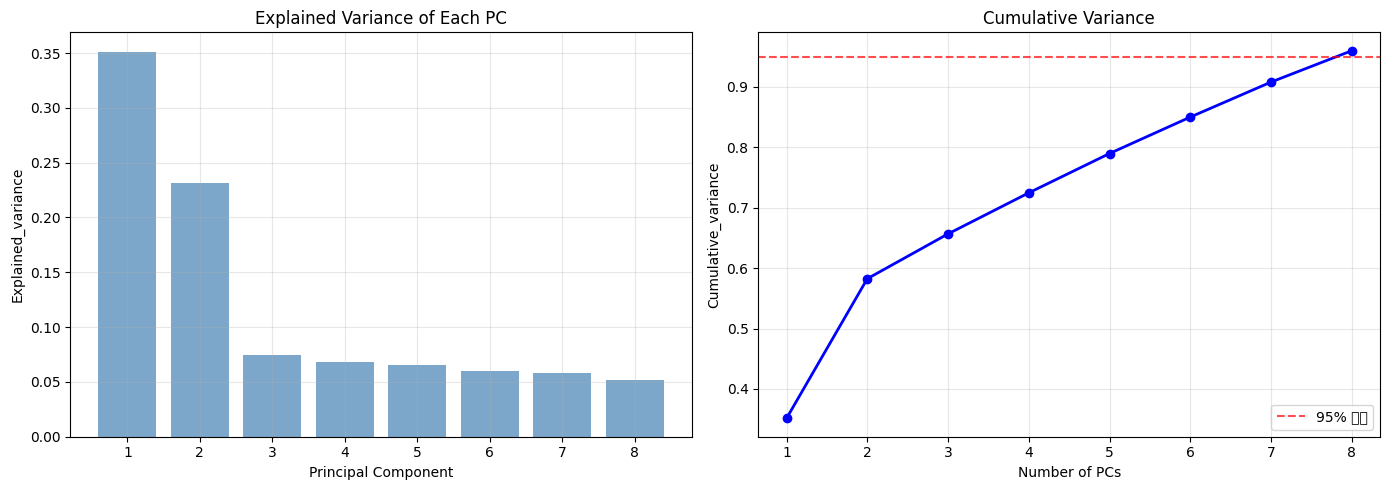


PCA transformation completed, using first8principal components
Training set shape: (3034, 8)
Test set shape: (759, 8)

Logistic regression running results (using PCA dimensionality-reduced features):
Training set accuracy: 0.6889
Test set accuracy: 0.7207
Time Cost： :	0.01s

Partial training data (after PCA transformation):
           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
3366  1.663220  0.468388 -0.572052  0.632931 -1.433654 -0.095577  1.421023   
3267  0.628916 -2.086959  0.142562 -0.097323 -0.338618  0.602088  1.737251   
1436  2.272575  3.981602  0.310299  1.216265  0.879277 -0.997591 -0.718741   
937   1.419243  2.941631  1.476059 -1.739194  0.237294  0.048384 -0.606768   
108  -2.406368  0.803360 -0.713482  0.629211 -1.340653 -0.515238 -0.188056   

           PC8  
3366  0.180785  
3267  0.138947  
1436 -0.887036  
937  -1.033926  
108  -1.224507  

Training labels:
3366    1.0
3267    0.0
1436    0.0
937     1.0
108     1.0
Name: HW, dtype: float64

In [15]:
# prediction (PCA)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dataset = {}
teamset ={}
result ={}

# Obtain annual processing data
for i in range(2022,2025):
    str1 = 'team_season_'+str(i)+'.txt'
    str2 = 'team_'+str(i)+'.txt'
    dataset[i] = load_dict_from_file_team_season(str1)
    teamset[i] = load_dict_from_file_team_ranking(str2)
    result[i] = data_operate(dataset[i], teamset[i])

res = result[2022]

# Merge Data
for i in range(2023,2025):
    res = pd.merge(res, result[i], how='outer')

# Divide the feature set and labels
y_label = res['HW']
X_feature = res.drop(['HW'],axis =1)

# Split into training and test sets
Train_data, Test_data, Train_y, Test_y = train_test_split(X_feature, y_label, test_size=0.2, random_state=42)

# ============ Adding PCA Feature Selection ============
# Save original feature names (for subsequent analysis)
original_features = Train_data.columns.tolist()
print(f"Original feature count: {len(original_features)}")
print(f"Feature examples: {original_features[:5]}...")

# 1. Standardize data (PCA is sensitive to data scale)
scaler = StandardScaler()
Train_data_scaled = scaler.fit_transform(Train_data)
Test_data_scaled = scaler.transform(Test_data)

# 2. Apply PCA
# Retain 95% variance (automatically select number of principal components)
pca = PCA(n_components=0.95, random_state=42)
Train_data_pca = pca.fit_transform(Train_data_scaled)
Test_data_pca = pca.transform(Test_data_scaled)

# 3. Print PCA information
print(f"\nFeature count after PCA dimensionality reduction: {pca.n_components_}")
print(f"Cumulative explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize cumulative explained variance
def plot_pca_variance(pca_model):
    plt.figure(figsize=(10, 6))

    # Explained variance ratio
    explained_variance = pca_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Subplot 1: Explained variance of each principal component
    ax1.bar(range(1, len(explained_variance) + 1), explained_variance,
            alpha=0.7, color='steelblue')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained_variance')
    ax1.set_title('Explained Variance of Each PC')
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Cumulative explained variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'b-', marker='o', linewidth=2)
    ax2.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% 阈值')
    ax2.set_xlabel('Number of PCs')
    ax2.set_ylabel('Cumulative_variance')
    ax2.set_title('Cumulative Variance')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Optional: Display PCA visualization
plot_pca_variance(pca)

# 4. Convert PCA results to DataFrame (maintain consistent data format)
Train_data_pca_df = pd.DataFrame(
    Train_data_pca,
    columns=[f'PC{i+1}' for i in range(Train_data_pca.shape[1])],
    index=Train_data.index
)
Test_data_pca_df = pd.DataFrame(
    Test_data_pca,
    columns=[f'PC{i+1}' for i in range(Test_data_pca.shape[1])],
    index=Test_data.index
)

# Update training and test data to PCA-transformed data
Train_data = Train_data_pca_df
Test_data = Test_data_pca_df

print(f"\nPCA transformation completed, using first{pca.n_components_}principal components")
print(f"Training set shape: {Train_data.shape}")
print(f"Test set shape: {Test_data.shape}")
# ============ End of PCA ============

# Logistic Regression learning results
print('\nLogistic regression running results (using PCA dimensionality-reduced features):')
t0 = time()
import sklearn.linear_model as sl
logitmodel = sl.LogisticRegression(random_state=42)  # Define regression model
logitmodel.fit(Train_data, Train_y)  # Train model
t = time() - t0

train_predictions = logitmodel.predict(Train_data)
test_predictions = logitmodel.predict(Test_data)

# Training set and test set accuracy
acc1 = train_predictions == list(Train_y)
print('Training set accuracy: %.4f' % (np.mean(acc1)))
acc2 = test_predictions== list(Test_y)
print('Test set accuracy: %.4f' % (np.mean(acc2)))

print("%s :\t%.2fs" % ('Time Cost：', t))

# Print partial data
print("\nPartial training data (after PCA transformation):")
print(Train_data.head())
print("\nTraining labels:")
print(Train_y.head())
print("\nModel predictions:")
print(logitmodel.predict(Train_data.head()))

In [16]:
# Team Match Data Processing（Pearson feature selection）
def data_operate_pearson(data, data_team):
    data = data.drop(['1', '2'], axis=1)
    data.rename(columns={'Visitor/Neutral': 'Visitor', 'Home/Neutral': 'Home'}, inplace=True)
    name_home = data['Home'].unique()
    data['HW'] = ((data['PTS2'].apply(float) - data['PTS1'].apply(float)) > 0).apply(int)
    data['PTS1'] = data['PTS1'].apply(int)
    data['PTS2'] = data['PTS2'].apply(int)
    cauculate_day(data)
    # print(name_home)
    points_gain(data, name_home)
    recent_behavior(data, name_home)
    cauculate_week(data)
    pts_ave_week(data)
    # delete_somedata(data2017)
    data = data[~data['hm3'].isin(['N'])]
    data = data[~data['vm3'].isin(['N'])]
    data.reset_index(inplace=True, drop=True)

    team_dict = get_feature_team(data_team)
    # print(team_dict)
    insert_features(data, team_dict)

    # Normalization
    str_convrt = ['hPTS_avew', 'vPTS_avew', 'hMOV', 'hNRtg', 'vMOV', 'vNRtg']
    for i in str_convrt:
        data[i] = convert_1(data[i])

    cols = ['hPTS_avew', 'vPTS_avew', 'hMOV', 'hNRtg', 'vMOV', 'vNRtg', 'hSco_avew', 'vSco_avew']
    for col in cols:
        data[col] = scale(data[col])

    # Constructing the final features used for training:
    feature = ['hm1', 'hm2', 'hm3', 'vm1', 'vm2', 'vm3', 'hPTS_avew', 'vPTS_avew', 'hSco_avew', 'vSco_avew', 'hMOV',
               'hNRtg', 'vMOV', 'vNRtg']
    X_feature = data[feature]
    y_label = data['HW']

    # delete features with high correlation
    X_feature = X_feature.drop(['vSco_avew', 'vMOV', 'hMOV', 'vPTS_avew'], axis=1)

    # Constructing a Pearson correlation heatmap
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    train_data=pd.concat([X_feature,y_label],axis=1)
    colormap = plt.cm.RdBu
    plt.figure(figsize=(21,18))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0,
                square=True, cmap=colormap, linecolor='white', annot=True)
    plt.show()
    train_data = pd.concat([X_feature, y_label], axis=1)
    for i in list(train_data):
        train_data[i] = train_data[i].apply(float)
    return train_data

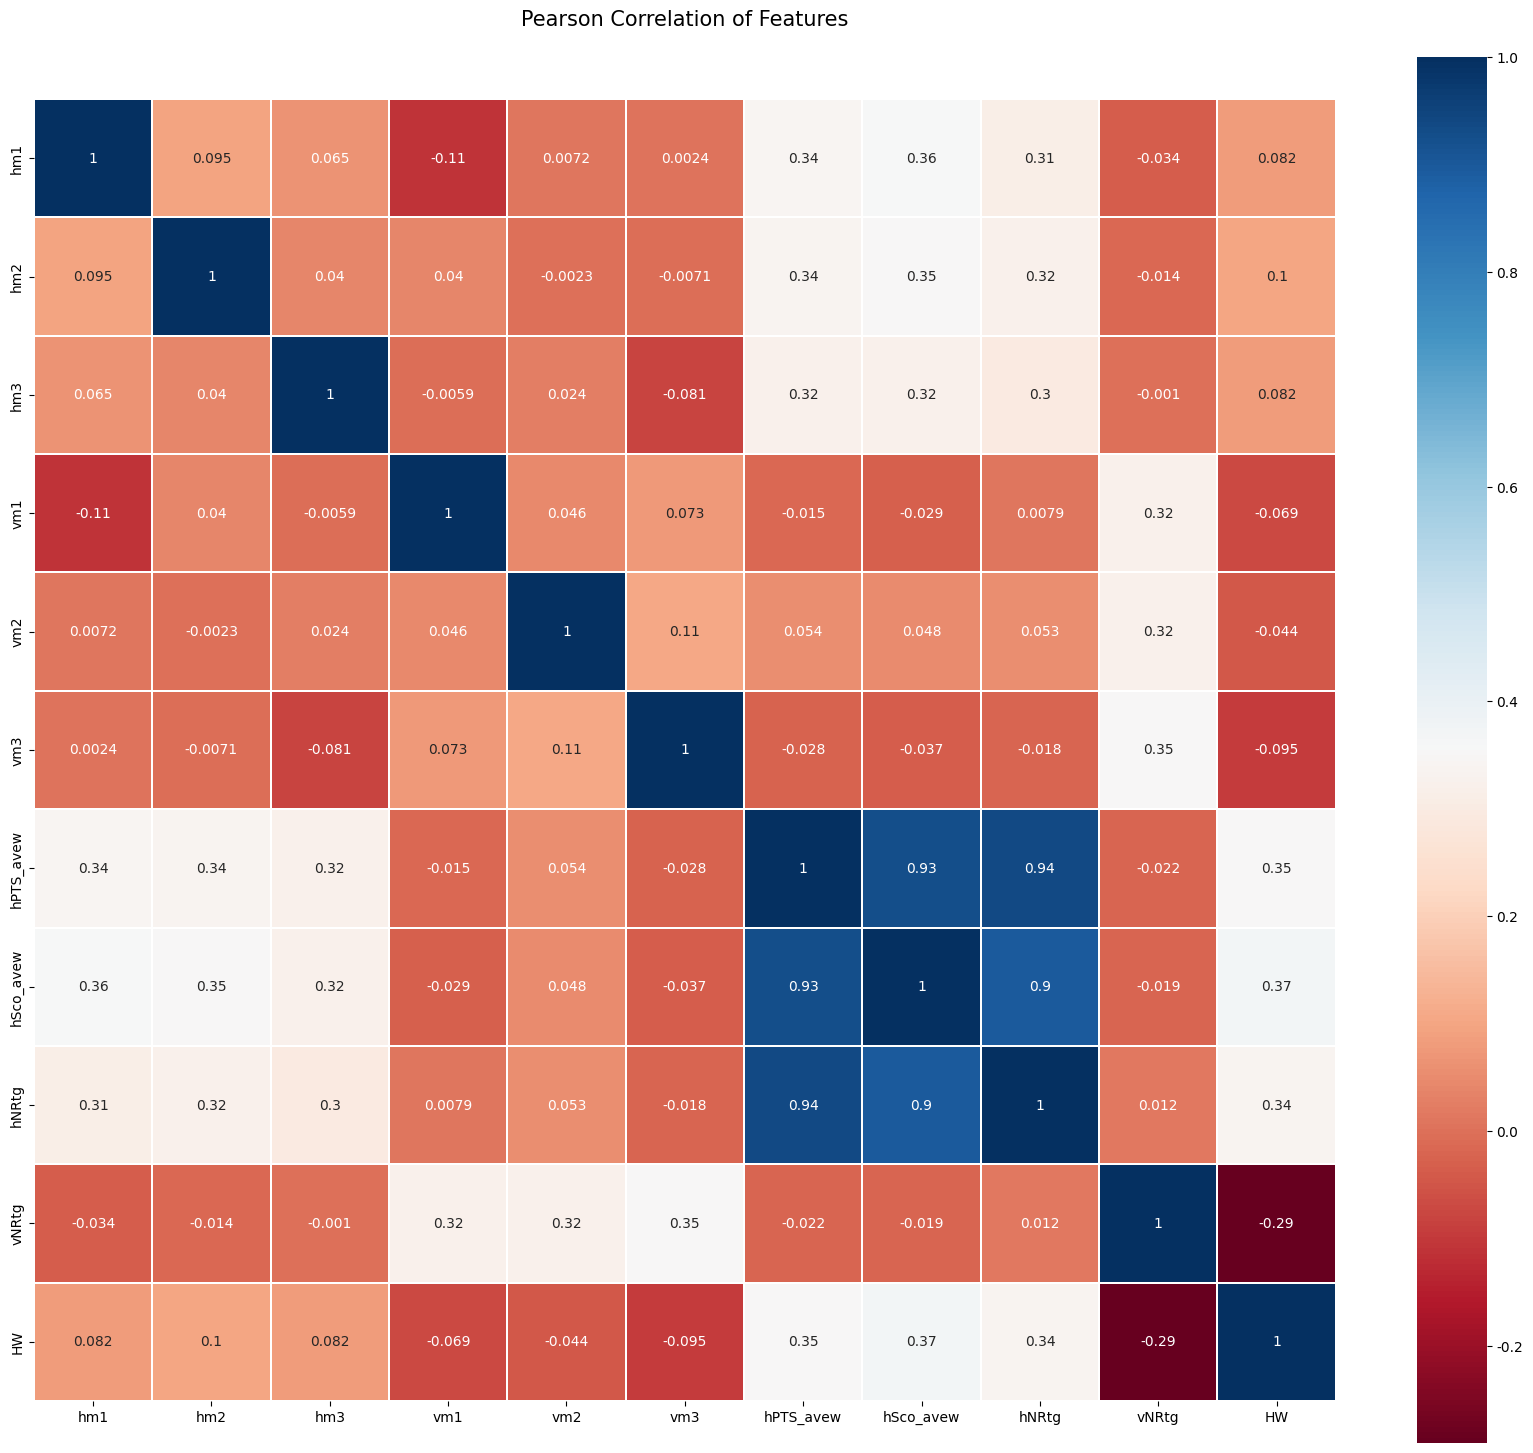

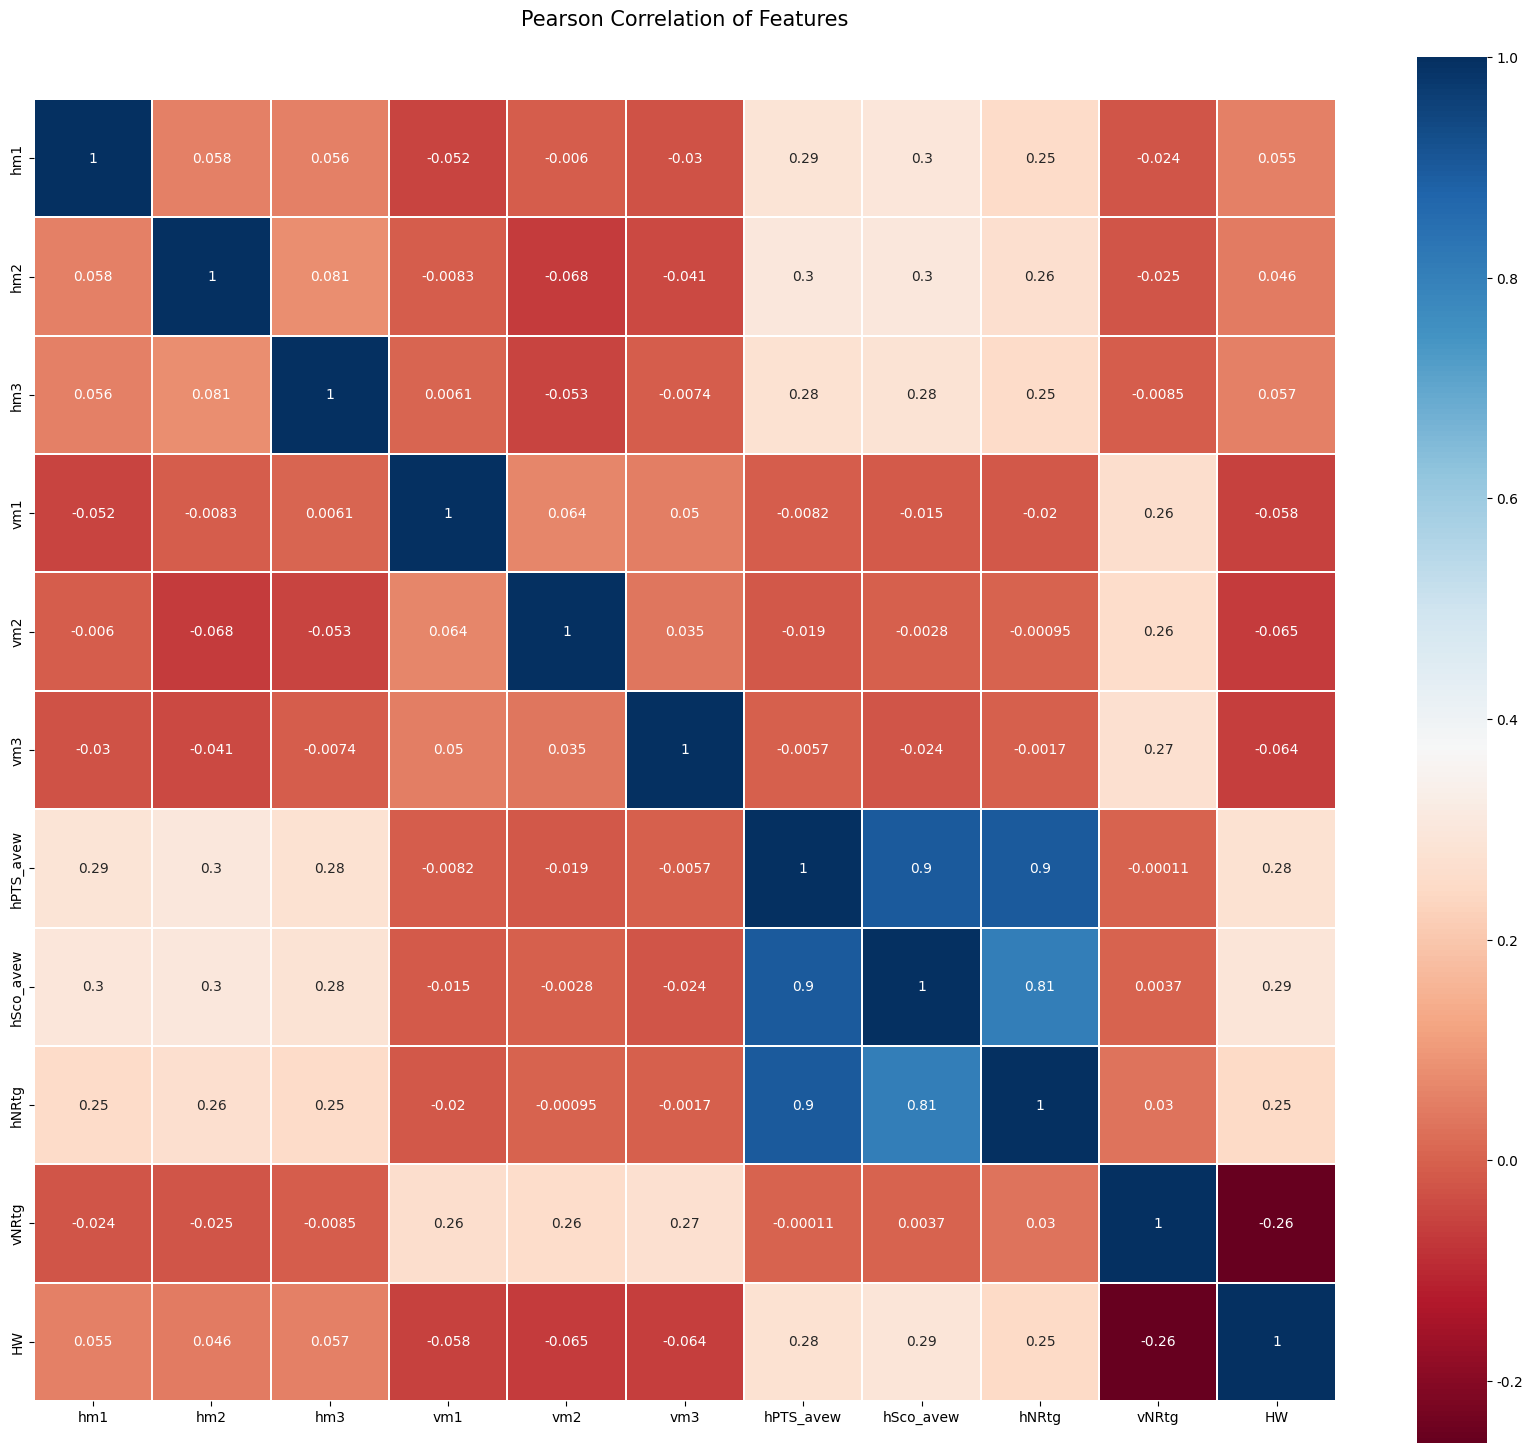

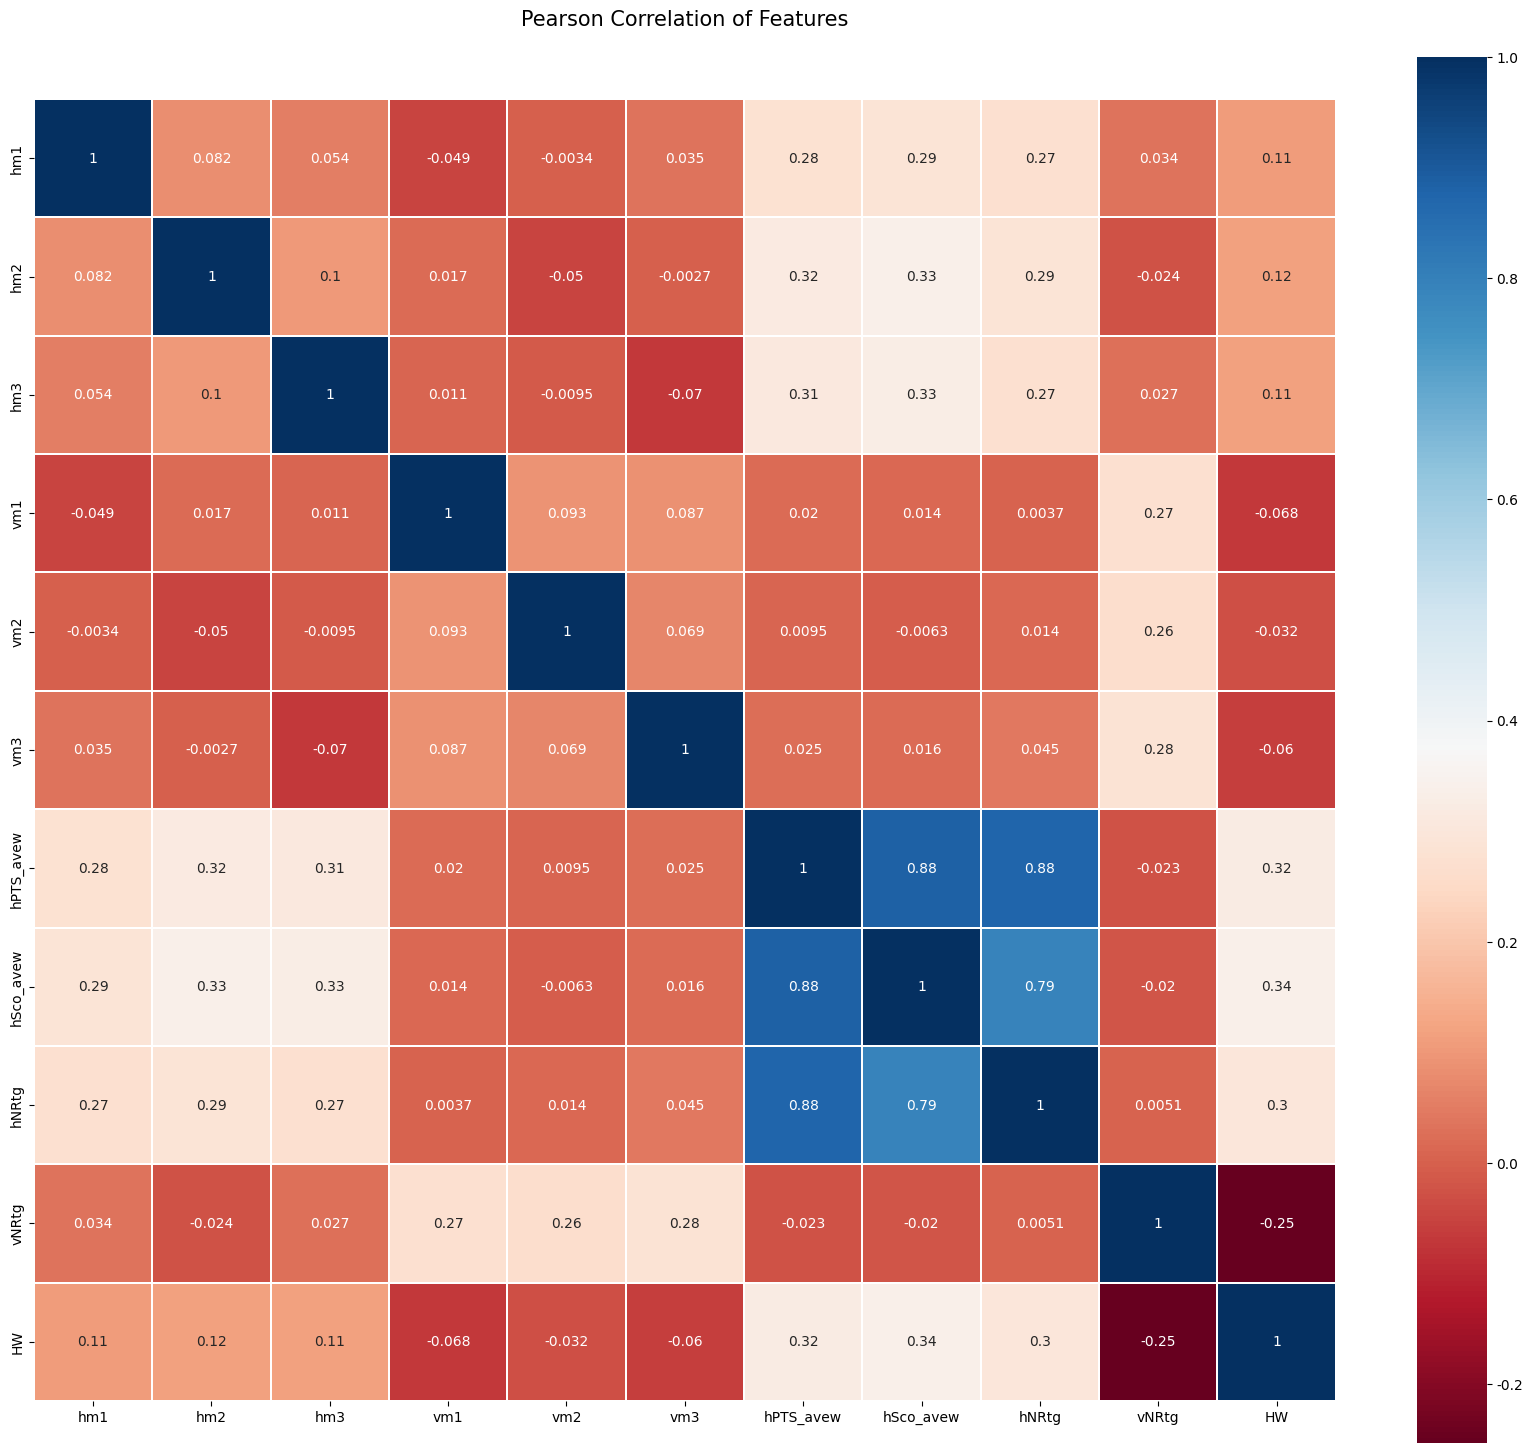

Logistic regression learning results：
Accuracy_train:0.690508
Accuracy_test:0.714097
Time cost： :	0.03s
      hm1  hm2  hm3  vm1  vm2  vm3  hPTS_avew  hSco_avew     hNRtg     vNRtg
604   0.0  0.0  1.0  0.0  0.0  0.0  -0.289357  -0.308580  0.095712 -0.171763
1046  0.0  1.0  0.0  0.0  0.0  0.0  -0.732765  -0.402751 -0.985948 -0.472237
763   0.0  0.0  1.0  0.0  1.0  1.0  -0.379127   0.351516 -0.500249  2.109535
551   0.0  0.0  0.0  1.0  1.0  1.0   0.074513   0.237609  0.212019 -0.171763
1917  1.0  0.0  0.0  0.0  0.0  0.0   0.106453   0.369447  0.212019 -0.676465
...   ...  ...  ...  ...  ...  ...        ...        ...       ...       ...
3666  1.0  1.0  1.0  1.0  1.0  0.0   0.235467  -0.383917 -0.176448  1.703853
2305  1.0  0.0  0.0  1.0  1.0  1.0  -0.012435  -0.411536 -0.045007  0.235894
2042  1.0  0.0  0.0  0.0  1.0  0.0   0.190791   0.290410  0.232284 -2.075357
2071  1.0  0.0  0.0  0.0  1.0  1.0  -0.539460  -0.491118 -0.655556 -0.336520
3344  1.0  1.0  1.0  0.0  0.0  1.0   0.441514   0

In [17]:
# prediction（Pearson feature selection）
dataset = {}
teamset ={}
result ={}

# Obtain annual processing data
for i in range(2022,2025):
    str1 = 'team_season_'+str(i)+'.txt'
    str2 = 'team_'+str(i)+'.txt'
    dataset[i] = load_dict_from_file_team_season(str1)
    teamset[i] = load_dict_from_file_team_ranking(str2)
    result[i] = data_operate_pearson(dataset[i], teamset[i])

res = result[2022]

# Merge Data
for i in range(2023,2025):
    # print(res.info())
    # print(result[i].info())
    res = pd.merge(res, result[i], how='outer')

# Divide the feature set and labels
y_label = res['HW']
X_feature = res.drop(['HW'],axis =1)

# Split into training and test sets
Train_data, Test_data, Train_y, Test_y = train_test_split(X_feature, y_label, test_size=0.2)

# Logistic regression learning results
print('Logistic regression learning results：')
t0 = time()
import sklearn.linear_model as sl
logitmodel=sl.LogisticRegression()#Define regression model
logitmodel.fit(Train_data,Train_y)#Training Model
# print(classification_report(y_test,logitmodel.predict(x_test)))
# print(classification_report(Test_y,logitmodel.predict(Test_data)))
acc1 = logitmodel.predict(Train_data) == list(Train_y)
print('Accuracy_train:%f' % (np.mean(acc1)))
acc2 = logitmodel.predict(Test_data) == list(Test_y)
print('Accuracy_test:%f' % (np.mean(acc2)))
t = time() - t0
print("%s :\t%.2fs" % ('Time cost：', t))

print(Train_data)
print(Train_y)
print(logitmodel.predict(Train_data))

In [18]:
# ============ 保存预测结果到文件 ============
import os
from datetime import datetime

# 创建结果保存目录
output_dir = 'prediction_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 生成时间戳
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. 保存训练集预测结果
train_results = pd.DataFrame({
    'Index': Train_data.index,
    'True_Label': Train_y.values,
    'Predicted_Label': train_predictions,
    'Is_Correct': train_predictions == Train_y.values
})

train_filename = f'{output_dir}/train_predictions_{timestamp}.csv'
train_results.to_csv(train_filename, index=False)
print(f"\n训练集预测结果已保存到: {train_filename}")
print(f"训练集记录数: {len(train_results)}")

# 2. 保存测试集预测结果
test_results = pd.DataFrame({
    'Index': Test_data.index,
    'True_Label': Test_y.values,
    'Predicted_Label': test_predictions,
    'Is_Correct': test_predictions == Test_y.values
})

test_filename = f'{output_dir}/test_predictions_{timestamp}.csv'
test_results.to_csv(test_filename, index=False)
print(f"测试集预测结果已保存到: {test_filename}")
print(f"测试集记录数: {len(test_results)}")


训练集预测结果已保存到: prediction_results/train_predictions_20251214_212517.csv
训练集记录数: 3034
测试集预测结果已保存到: prediction_results/test_predictions_20251214_212517.csv
测试集记录数: 759


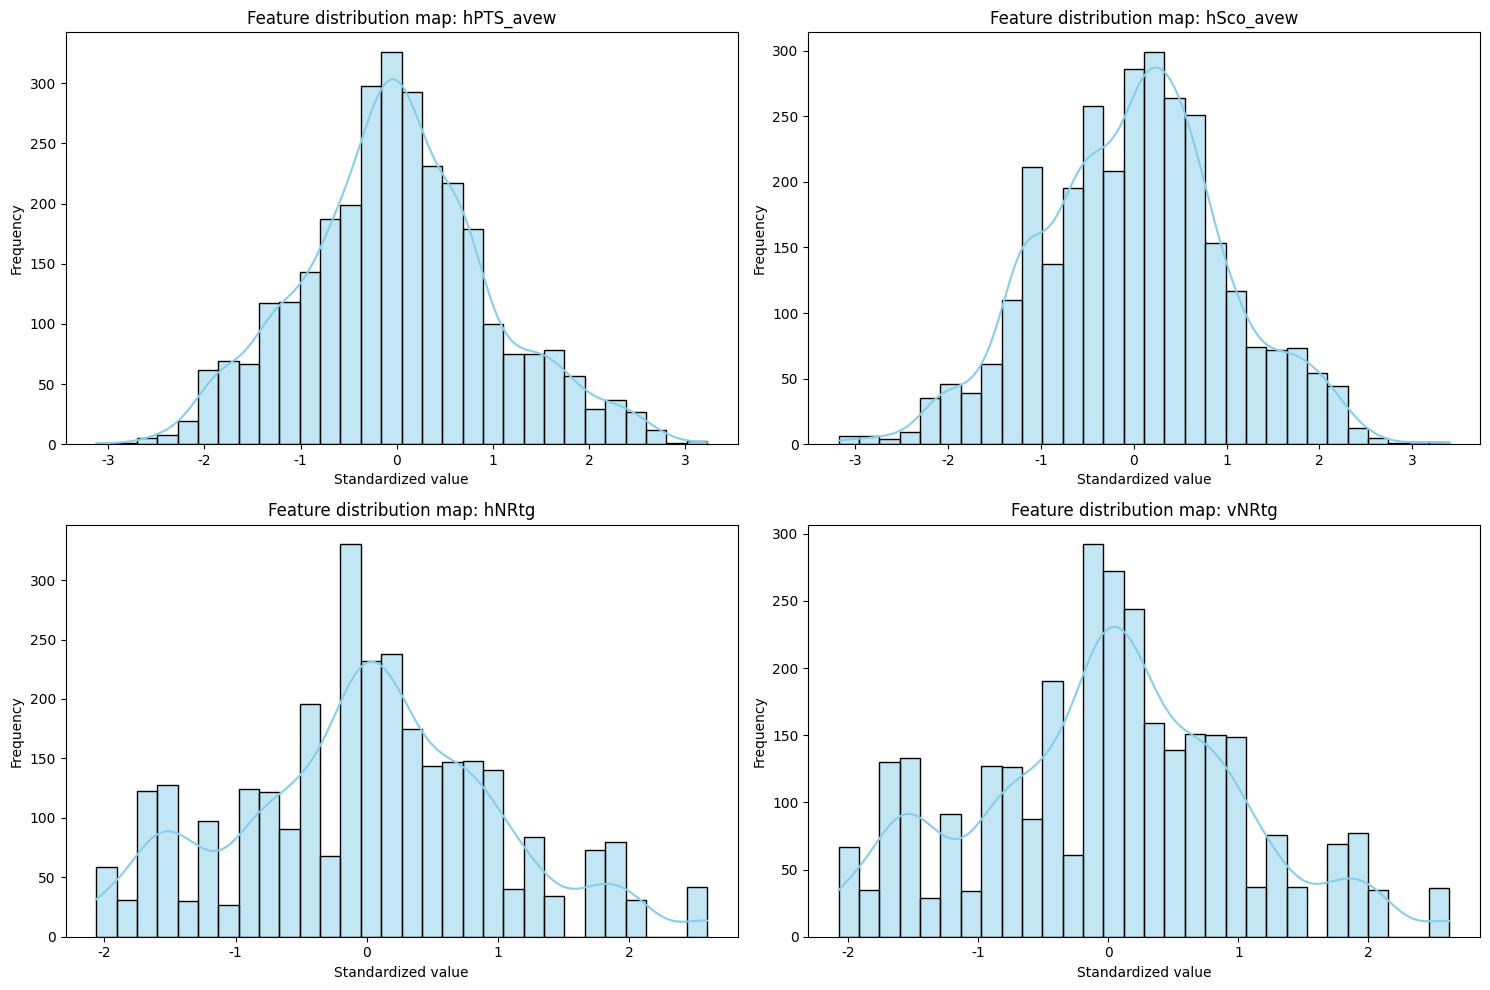

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select normalized continuous features from Train_data for visualization

# These features are: 'hPTS_avew', 'hSco_avew', 'hNRtg', 'vNRtg'

# They are normalized (scaled) in Cell 53
viz_features = ['hPTS_avew', 'hSco_avew', 'hNRtg', 'vNRtg']

plt.figure(figsize=(15, 10))

# Traverse and plot the distribution of each feature
for i, col in enumerate(viz_features):
    plt.subplot(2, 2, i + 1) # 2x2 subgraph layout

   # Use Seaborn's distplot (or the latest histplot)

    # kde=True will plot the kernel density estimation line
    sns.histplot(Train_data[col], kde=True, bins=30, color='skyblue')

    plt.title(f'Feature distribution map: {col}')
    plt.xlabel('Standardized value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()